# Stock Research Example using the SWARM team

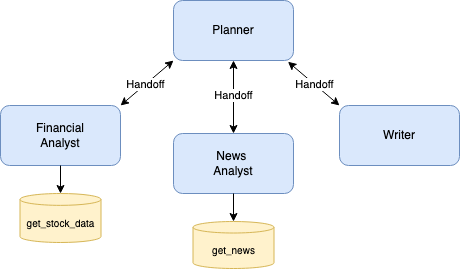

### This system is designed to perform stock research tasks by leveraging four agents:

- Planner: The central coordinator that delegates specific tasks to specialized agents based on their expertise. The planner ensures that each agent is utilized efficiently and oversees the overall workflow.

- Financial Analyst: A specialized agent responsible for analyzing financial metrics and stock data using tools such as get_stock_data.

- News Analyst: An agent focused on gathering and summarizing recent news articles relevant to the stock, using tools such as get_news.

- Writer: An agent tasked with compiling the findings from the stock and news analysis into a cohesive final report.

## Workflow
1. The Planner initiates the research process by delegating tasks to the appropriate agents in a step-by-step manner.

2. Each agent performs its task independently and appends their work to the shared message thread/history. Rather than directly returning results to the planner, all agents contribute to and read from this shared message history. When agents generate their work using the LLM, they have access to this shared message history, which provides context and helps track the overall progress of the task.

3. Once an agent completes its task, it hands off control back to the planner.

4. The process continues until the planner determines that all necessary tasks have been completed and decides to terminate the workflow.

## Load dependencies

In [1]:
from typing import Any, Dict, List

from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.conditions import HandoffTermination, TextMentionTermination
from autogen_agentchat.messages import HandoffMessage
from autogen_agentchat.teams import Swarm
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import AzureOpenAIChatCompletionClient
import yaml


## Let's define some tools first

In [2]:
def get_news(query: str, num_results: int = 2, max_chars: int = 500) -> list:  # type: ignore[type-arg]
    import os
    import time

    import requests
    from bs4 import BeautifulSoup
    from dotenv import load_dotenv

    load_dotenv()

    api_key = os.getenv("GOOGLE_API_KEY")
    search_engine_id = os.getenv("GOOGLE_SEARCH_ENGINE_ID")

    if not api_key or not search_engine_id:
        raise ValueError("API key or Search Engine ID not found in environment variables")

    url = "https://customsearch.googleapis.com/customsearch/v1"
    params = {"key": str(api_key), "cx": str(search_engine_id), "q": str(query), "num": str(num_results)}

    response = requests.get(url, params=params)

    if response.status_code != 200:
        print(response.json())
        raise Exception(f"Error in API request: {response.status_code}")

    results = response.json().get("items", [])

    def get_page_content(url: str) -> str:
        try:
            response = requests.get(url, timeout=10)
            soup = BeautifulSoup(response.content, "html.parser")
            text = soup.get_text(separator=" ", strip=True)
            words = text.split()
            content = ""
            for word in words:
                if len(content) + len(word) + 1 > max_chars:
                    break
                content += " " + word
            return content.strip()
        except Exception as e:
            print(f"Error fetching {url}: {str(e)}")
            return ""

    enriched_results = []
    for item in results:
        body = get_page_content(item["link"])
        enriched_results.append(
            {"title": item["title"], "link": item["link"], "snippet": item["snippet"], "body": body}
        )
        time.sleep(1)  # Be respectful to the servers

    return enriched_results




In [3]:
def get_stock_data(ticker: str) -> dict:  # type: ignore[type-arg]
    import os
    from datetime import datetime, timedelta

    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import yfinance as yf
    from pytz import timezone  # type: ignore

    stock = yf.Ticker(ticker)

    # Get historical data (1 year of data to ensure we have enough for 200-day MA)
    end_date = datetime.now(timezone("UTC"))
    start_date = end_date - timedelta(days=365)
    hist = stock.history(start=start_date, end=end_date)

    # Ensure we have data
    if hist.empty:
        return {"error": "No historical data available for the specified ticker."}

    # Compute basic statistics and additional metrics
    current_price = stock.info.get("currentPrice", hist["Close"].iloc[-1])
    year_high = stock.info.get("fiftyTwoWeekHigh", hist["High"].max())
    year_low = stock.info.get("fiftyTwoWeekLow", hist["Low"].min())

    # Calculate 50-day and 200-day moving averages
    ma_50 = hist["Close"].rolling(window=50).mean().iloc[-1]
    ma_200 = hist["Close"].rolling(window=200).mean().iloc[-1]

    # Calculate YTD price change and percent change
    ytd_start = datetime(end_date.year, 1, 1, tzinfo=timezone("UTC"))
    ytd_data = hist.loc[ytd_start:]  # type: ignore[misc]
    if not ytd_data.empty:
        price_change = ytd_data["Close"].iloc[-1] - ytd_data["Close"].iloc[0]
        percent_change = (price_change / ytd_data["Close"].iloc[0]) * 100
    else:
        price_change = percent_change = np.nan

    # Determine trend
    if pd.notna(ma_50) and pd.notna(ma_200):
        if ma_50 > ma_200:
            trend = "Upward"
        elif ma_50 < ma_200:
            trend = "Downward"
        else:
            trend = "Neutral"
    else:
        trend = "Insufficient data for trend analysis"

    # Calculate volatility (standard deviation of daily returns)
    daily_returns = hist["Close"].pct_change().dropna()
    volatility = daily_returns.std() * np.sqrt(252)  # Annualized volatility

    # Create result dictionary
    result = {
        "ticker": ticker,
        "current_price": current_price,
        "52_week_high": year_high,
        "52_week_low": year_low,
        "50_day_ma": ma_50,
        "200_day_ma": ma_200,
        "ytd_price_change": price_change,
        "ytd_percent_change": percent_change,
        "trend": trend,
        "volatility": volatility,
    }

    # Convert numpy types to Python native types for better JSON serialization
    for key, value in result.items():
        if isinstance(value, np.generic):
            result[key] = value.item()

    # Generate plot
    plt.figure(figsize=(12, 6))
    plt.plot(hist.index, hist["Close"], label="Close Price")
    plt.plot(hist.index, hist["Close"].rolling(window=50).mean(), label="50-day MA")
    plt.plot(hist.index, hist["Close"].rolling(window=200).mean(), label="200-day MA")
    plt.title(f"{ticker} Stock Price (Past Year)")
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.grid(True)

    # Save plot to file
    os.makedirs("coding", exist_ok=True)
    plot_file_path = f"coding/{ticker}_stockprice.png"
    plt.savefig(plot_file_path)
    print(f"Plot saved as {plot_file_path}")
    result["plot_file_path"] = plot_file_path

    return result


## create a model instance

In [4]:
with open("model_config_reasoning_model.yaml", "r") as f:
        model_config = yaml.safe_load(f)
model_client = AzureOpenAIChatCompletionClient.load_component(model_config)

In [5]:
planner = AssistantAgent(
    "planner",
    model_client=model_client,
    handoffs=["financial_analyst", "news_analyst", "writer"],
    
    system_message="""
    You are a research planning coordinator.
    Coordinate market research by delegating to specialized agents:
    - Financial Analyst: For stock data analysis
    - News Analyst: For news gathering and analysis
    - Writer: For compiling final report
    Always send your plan first, then handoff to appropriate agent.
    Always handoff to a single agent at a time.
    Use TERMINATE when research is complete, end END the conversation when the writer completes the report for the first time.
    """,
)

financial_analyst = AssistantAgent(
    "financial_analyst",
    model_client=model_client,
    handoffs=["planner"],
    tools=[get_stock_data],
    system_message="""
    You are a financial analyst.
    Analyze stock market data using the get_stock_data tool.
    Provide insights on financial metrics.
    Always handoff back to planner when analysis is complete.
    """,
)

news_analyst = AssistantAgent(
    "news_analyst",
    model_client=model_client,
    handoffs=["planner"],
    tools=[get_news],
    system_message="""
    You are a news analyst.
    Gather and analyze relevant news using the get_news tool.
    Summarize key market insights from news.
    Always handoff back to planner when analysis is complete.
    """,
)

writer = AssistantAgent(
    "writer",
    model_client=model_client,
    handoffs=["planner"],
    system_message="""
    You are a financial report writer.
    Compile research findings into clear, concise reports.
    Always handoff back to planner when writing is complete, and indicate that the report is ready.
    """,
)


---------- TextMessage (user) ----------
Conduct market research for TSLA stock
---------- ToolCallRequestEvent (planner) ----------
[FunctionCall(id='call_8Abz3cjCYM1xZ2gU0vo1IEMy', arguments='{}', name='transfer_to_financial_analyst')]
---------- ToolCallExecutionEvent (planner) ----------
[FunctionExecutionResult(content='Transferred to financial_analyst, adopting the role of financial_analyst immediately.', name='transfer_to_financial_analyst', call_id='call_8Abz3cjCYM1xZ2gU0vo1IEMy', is_error=False)]
---------- HandoffMessage (planner) ----------
Transferred to financial_analyst, adopting the role of financial_analyst immediately.
---------- ToolCallRequestEvent (financial_analyst) ----------
[FunctionCall(id='call_ZJdZ5aNdix5iNxLGCEkviHH9', arguments='{"ticker":"TSLA"}', name='get_stock_data')]
Plot saved as coding/TSLA_stockprice.png
---------- ToolCallExecutionEvent (financial_analyst) ----------
[FunctionExecutionResult(content="{'ticker': 'TSLA', 'current_price': 284.95, '52_

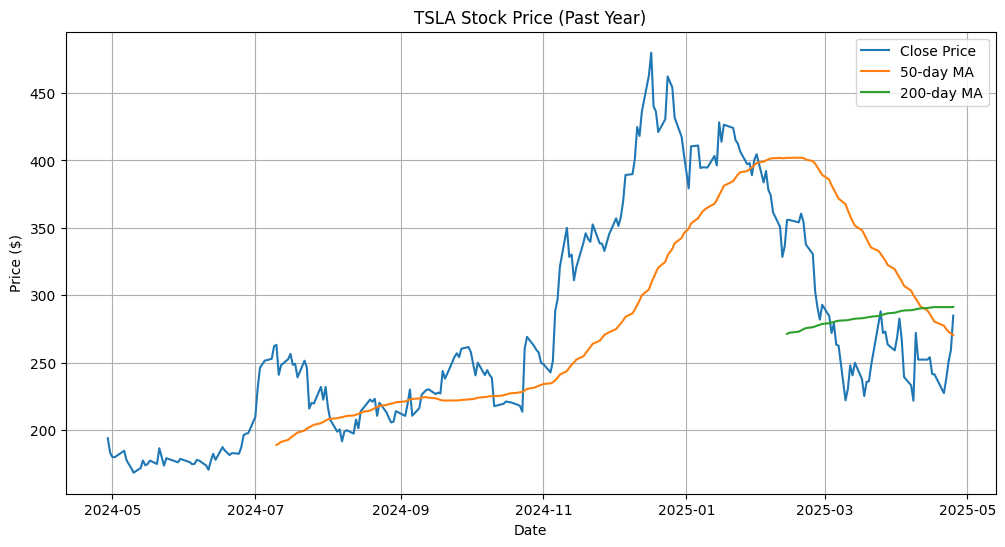

In [6]:
# Define termination condition
text_termination = TextMentionTermination("TERMINATE")
termination = text_termination

research_team = Swarm(
    participants=[planner, financial_analyst, news_analyst, writer], termination_condition=termination
)

task = "Conduct market research for TSLA stock"
await Console(research_team.run_stream(task=task))
await model_client.close()
